In [1]:
import pandas as pd
from datasets import load_dataset
from torchtuning import koalpaca_dataset, kowiki_dataset, text_completion_dataset
from torchtune.models.llama3 import llama3_tokenizer
import numpy as np

In [2]:
tokenizer = llama3_tokenizer('checkpoints/Meta-Llama-3-8B/original/tokenizer.model')

In [3]:
a = kowiki_dataset(tokenizer=tokenizer, data_files='data/20240520/kowikitext_20240520.csv', split='train')

In [5]:
lens = []
for i in range(len(a._data)):
    tmp = a._data[i]['text']
    length = 0 if tmp is None else len(tmp)
    lens.append(length)

In [6]:
lens = np.array(lens)

In [7]:
np.argsort(-lens)[:10]

array([  73537,  911293,  323624, 1036507,  879304,  365621,   93424,
       1015018,  635115,  542477])

In [8]:
i = 73537
len(a._data[i]['text'])

1634129

In [14]:
a._tokenizer.device

AttributeError: 'TikTokenTokenizer' object has no attribute 'device'

In [12]:
len(a[i][0])

2047

In [9]:
print(a._data[i]['text'])

= 국가보안법 사건 목록 =

이 문서는 대한민국의 국가보안법 사건 목록이다.

= = 사건 목록  = =

= = = 이승만 정부  = = =

연월일             	사건번호                 	사건명                                                                     	주문                                                                                                                                                                                                                                                                 	판사                  	비고
1949년 5월 31일    	서울지법                 	국가보안법위반이적죄                                                              	최능진 징역3년김진섭 징역3년6개월서세충 무죄                                                                                                                                                                                                                                          	                    	혁명의용군 사건
1949년 11월 2일    	서울고법                 	국가보안법위반이적죄                                                              	최능진 징역5년

In [36]:
lens.mean()

730.1533531756919

In [37]:
from matplotlib import pyplot as plt

In [44]:
lens

array([      0,       0,       0, ...,  688572,  989464, 1634129])

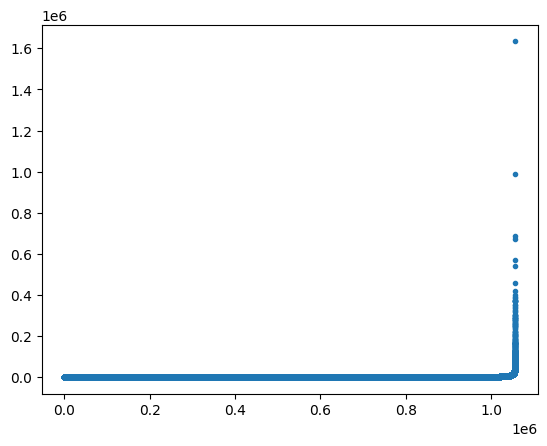

In [46]:
_ = plt.plot(lens, '.')

In [27]:
df = pd.read_csv('data/20240520/kowikitext_20240520.csv')

In [28]:
df

,text
0,"= 플라톤 =\n\n플라톤(, 플라톤, ""넓은, 어깨 폭이 넓은"";Diogenes ..."
1,= 1280년 =\n\n= = 연호 = =\n\n원(元) 지원(至元) 17년\n일...
2,= 버니 차우 =\n\n버니 차우 또는 버니는 남아프리카 공화국의 빵 요리이다.\n...
3,= 분류:회네포스 출신 =
4,= 장솜이 =\n\n장솜이(1991년 2월 25일 ~ )는 대한민국의 배우이다.장솜...
...,...
1056993,= 후치다카역 =\n\n후치다카역은 일본 아이치현 아이사이시에 위치한 나고야 철도 ...
1056994,= You & Me (카드의 EP) =\n\nYou & Me는 혼성그룹 KARD의 ...
1056995,= 컨피규레이션 =\n\n컨피규레이션(configuration) 또는 컨피그(con...
1056996,= 위키백과:면책 조항 =\n\n__NOTOC__\n위키백과는 정확성을 보증하지 않...


In [29]:
df.iloc[18]

text    = 니로역 =\n\n니로역은 일본 효고현 고베시 기타구에 있는 고베 전철 산다 선의...
Name: 18, dtype: object

In [32]:
df.iloc[21]

text    = 분류:오스트리아에 거주한 미국인 =
Name: 21, dtype: object

In [39]:
if 'a' is not None:
    print('djfsklafjksadl')
else:
    print('asdf')

djfsklafjksadl


<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_155820/3740105873.py:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if 'a' is not None:
